Problem 1 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pandas as pd
import os
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def load_cifar10_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict[b'data'], dict[b'labels']


def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    for i in range(1, 6):
        data_batch, label_batch = load_cifar10_batch(os.path.join(data_dir, f'data_batch_{i}'))
        train_data.append(data_batch)
        train_labels.append(label_batch)

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    test_data, test_labels = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))

    return train_data, train_labels, test_data, test_labels

In [3]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc4(self.relu(self.fc3(x)))
        return x

In [4]:
if __name__ == "__main__":
    cifar10_dir = r'C:\Users\SirM\Desktop\Swayam\Intro to ML\cifar-10-batches-py'

    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

Epoch 1, loss: 1.8728280584220691
Epoch 2, loss: 1.6899752929387495
Epoch 3, loss: 1.6044588156063537
Epoch 4, loss: 1.5430223575943267
Epoch 5, loss: 1.4951353713374613
Epoch 6, loss: 1.4601177466494957
Epoch 7, loss: 1.4291542390423357
Epoch 8, loss: 1.3969349444979597
Epoch 9, loss: 1.3665429954333683
Epoch 10, loss: 1.3482019833439147
Epoch 11, loss: 1.3264068130337063
Epoch 12, loss: 1.300162389760127
Epoch 13, loss: 1.2764356371082004
Epoch 14, loss: 1.2610445470761156
Epoch 15, loss: 1.241654386910636
Epoch 16, loss: 1.2196465992104366
Epoch 17, loss: 1.1999978234853281
Epoch 18, loss: 1.1828531859171054
Epoch 19, loss: 1.166494808767153
Epoch 20, loss: 1.146941259846358
Accuracy: 52.11 %
Precision: 0.5161150758662224
Recall: 0.5211
F1 Score: 0.5162493345764286
Total parameters: 1738890


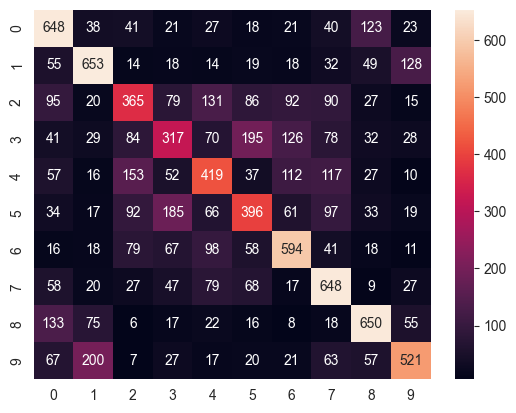

In [5]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 20
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation accuracy
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_running_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(testloader))
    val_accuracy.append(100 * correct / total)

# Evaluating the model
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')

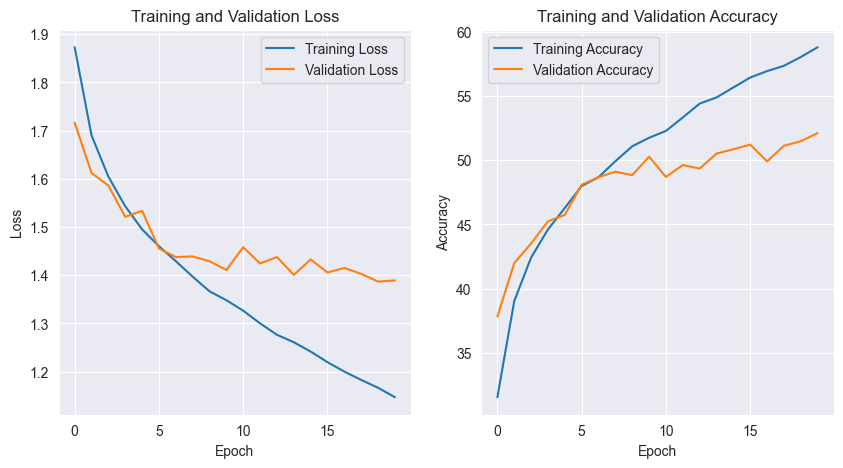

In [6]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1B

In [7]:
class MLP_extended(nn.Module):
    def __init__(self):
        super(MLP_extended, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 1024)  # Increased width
        self.fc2 = nn.Linear(1024, 512)  # Increased width
        self.fc3 = nn.Linear(512, 256)  # Increased width
        self.fc4 = nn.Linear(256, 128)  # Increased width
        self.fc5 = nn.Linear(128, 64)  # Additional layer
        self.fc6 = nn.Linear(64, 10)  # Additional layer, output matches the number of classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  # Pass through the additional layer
        return x

In [8]:
if __name__ == "__main__":
    cifar10_dir = r'C:\Users\SirM\Desktop\Swayam\Intro to ML\cifar-10-batches-py'

    train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar10_dir)
    train_data = torch.tensor(train_data, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_data = torch.tensor(test_data, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    train_data /= 255.0
    test_data /= 255.0

    trainloader = torch.utils.data.DataLoader(list(zip(train_data, train_labels)), batch_size=64, shuffle=True)
    testloader = torch.utils.data.DataLoader(list(zip(test_data, test_labels)), batch_size=64, shuffle=False)

Epoch 1, loss: 1.938616230512214
Epoch 2, loss: 1.7595217956606384
Epoch 3, loss: 1.6643451165665142
Epoch 4, loss: 1.5916671021210262
Epoch 5, loss: 1.5472478555596394
Epoch 6, loss: 1.50346971198421
Epoch 7, loss: 1.4637317962353797
Epoch 8, loss: 1.43069788714504
Epoch 9, loss: 1.39701598867431
Epoch 10, loss: 1.369593734631453
Epoch 11, loss: 1.345794441602419
Epoch 12, loss: 1.3145560972068622
Epoch 13, loss: 1.2890916886689412
Epoch 14, loss: 1.267363722367055
Epoch 15, loss: 1.2450175785347628
Epoch 16, loss: 1.2141566584482217
Epoch 17, loss: 1.193365265036483
Epoch 18, loss: 1.1661562605587112
Epoch 19, loss: 1.149390399837128
Epoch 20, loss: 1.1226721141496887
Accuracy: 51.27 %
Precision: 0.5120822982546145
Recall: 0.5126999999999999
F1 Score: 0.5058603049534512
Total parameters: 3844682


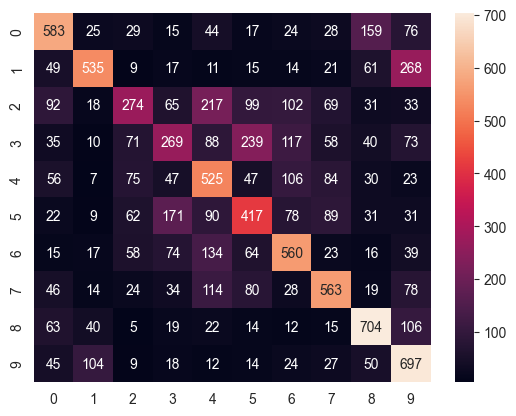

In [9]:
model = MLP_extended().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 20
train_loss = []
train_accuracy = []
val_accuracy = []
val_loss = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')

    train_loss.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation accuracy
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    val_running_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss.append(val_running_loss / len(testloader))
    val_accuracy.append(100 * correct / total)

# Evaluating the model
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
conf_mat = confusion_matrix(y_true, y_pred)

accuracy = 100 * correct / total
print(f'Accuracy: {accuracy} %')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
sns.heatmap(conf_mat, annot=True, fmt='d')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')

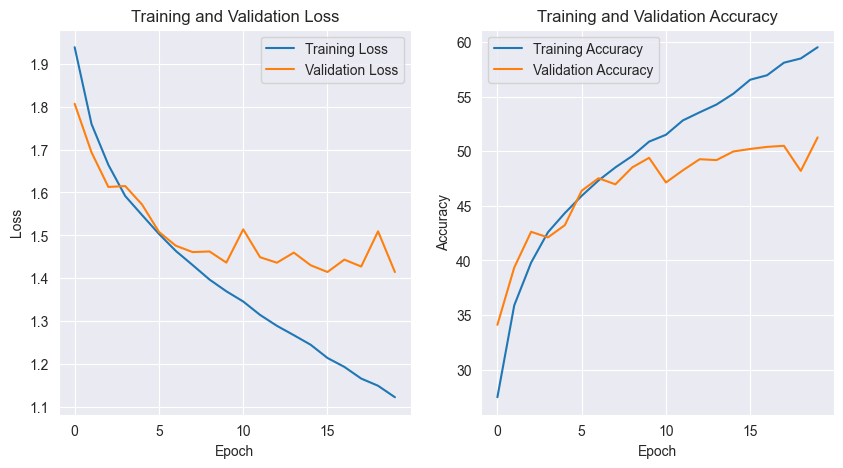

In [10]:
# Plotting training loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Problem 2

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

Epoch 1/100, Train Loss: 197127.9954, Val Loss: 196707.7094
Epoch 2/100, Train Loss: 196481.4869, Val Loss: 196634.0859
Epoch 3/100, Train Loss: 196181.6026, Val Loss: 196225.2875
Epoch 4/100, Train Loss: 194906.3239, Val Loss: 194813.9047
Epoch 5/100, Train Loss: 192747.4172, Val Loss: 191277.5219
Epoch 6/100, Train Loss: 187528.4772, Val Loss: 183825.1234
Epoch 7/100, Train Loss: 177505.5025, Val Loss: 170679.6031
Epoch 8/100, Train Loss: 160416.0752, Val Loss: 149574.2125
Epoch 9/100, Train Loss: 136038.7392, Val Loss: 120177.8703
Epoch 10/100, Train Loss: 107423.5750, Val Loss: 89423.0609
Epoch 11/100, Train Loss: 84999.7974, Val Loss: 72519.3199
Epoch 12/100, Train Loss: 76616.8435, Val Loss: 67621.5078
Epoch 13/100, Train Loss: 73877.1825, Val Loss: 65371.2223
Epoch 14/100, Train Loss: 72062.7678, Val Loss: 63583.2449
Epoch 15/100, Train Loss: 69827.2903, Val Loss: 61733.0008
Epoch 16/100, Train Loss: 67869.2239, Val Loss: 60071.3039
Epoch 17/100, Train Loss: 66388.0785, Val Loss

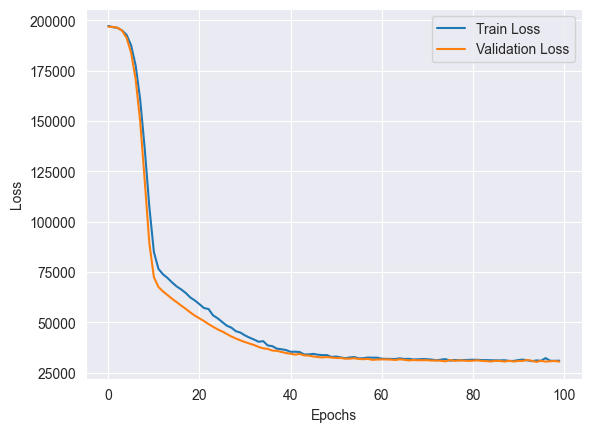

Total parameters: 11905


In [12]:
# Load dataset
df_train = pd.read_csv('C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Datasets/house-train.csv')
df_test = pd.read_csv('C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Datasets/house-test.csv')
# Define useful columns and preprocess the dataset
usefull_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
                'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
                'OpenPorchSF']
target_col = 'SalePrice'

df_train_prepro = df_train[usefull_cols + [target_col]].copy()

# Handle missing values
df_train_prepro.fillna(df_train_prepro.mean(), inplace=True)

# Split dataset into features and target
X = df_train_prepro[usefull_cols]
y = df_train_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
val_dataset = TensorDataset(X_val_tensor, y_val_tensor.view(-1, 1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)


model = MLP(len(usefull_cols))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    y_pred = []
    y_true = []
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            y_pred.extend(output.view(-1).tolist())
            y_true.extend(y_batch.view(-1).tolist())
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
mse = mean_squared_error(y_true, y_pred)
rmse = mse**0.5
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')

2B

In [13]:
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

# Select columns for training and preprocessing
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Identify numeric and categorical columns
numeric_cols = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

# For numeric columns, fill with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# For categorical columns, fill with mode or a placeholder value
for col in categorical_cols:
    df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# One-hot encoding for categorical features
categorical_features = ['ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
                        'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_features)

# Split dataset into features and target
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        return self.fc4(x)

model = MLP(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')

Epoch 1/100, Train Loss: 196815.6669, Val Loss: 199341.7375
Epoch 2/100, Train Loss: 197789.3191, Val Loss: 199335.3687
Epoch 3/100, Train Loss: 196698.9794, Val Loss: 199307.4062
Epoch 4/100, Train Loss: 197287.5905, Val Loss: 199213.0844
Epoch 5/100, Train Loss: 195780.9630, Val Loss: 198955.5812
Epoch 6/100, Train Loss: 194194.7944, Val Loss: 198372.3062
Epoch 7/100, Train Loss: 194129.7492, Val Loss: 197198.3000
Epoch 8/100, Train Loss: 193758.4112, Val Loss: 195081.8687
Epoch 9/100, Train Loss: 192177.4424, Val Loss: 191513.4750
Epoch 10/100, Train Loss: 186201.6949, Val Loss: 185950.6938
Epoch 11/100, Train Loss: 180077.8224, Val Loss: 178030.2031
Epoch 12/100, Train Loss: 171040.8199, Val Loss: 167025.3844
Epoch 13/100, Train Loss: 159224.5798, Val Loss: 152617.6812
Epoch 14/100, Train Loss: 144591.9071, Val Loss: 135279.3172
Epoch 15/100, Train Loss: 127855.2817, Val Loss: 117378.3031
Epoch 16/100, Train Loss: 111816.1583, Val Loss: 102032.9969
Epoch 17/100, Train Loss: 100839.

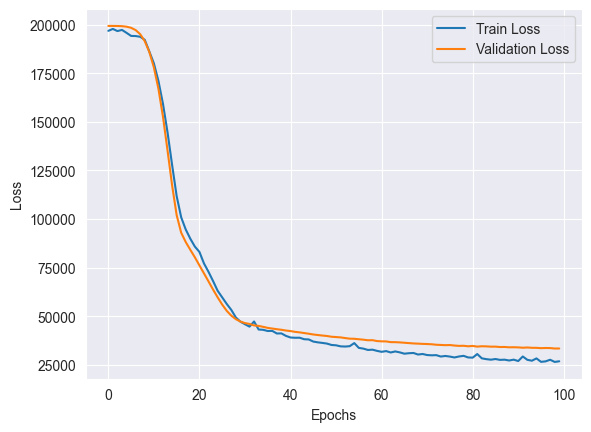

In [14]:
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2C

Epoch 1/100, Train Loss: 196841.2755, Val Loss: 199210.1781
Epoch 2/100, Train Loss: 196248.1908, Val Loss: 193097.0562
Epoch 3/100, Train Loss: 163732.9979, Val Loss: 102974.8125
Epoch 4/100, Train Loss: 67605.5438, Val Loss: 48509.4187
Epoch 5/100, Train Loss: 39818.7698, Val Loss: 36176.4352
Epoch 6/100, Train Loss: 31841.0137, Val Loss: 34976.0238
Epoch 7/100, Train Loss: 29329.1092, Val Loss: 33182.6750
Epoch 8/100, Train Loss: 27508.1517, Val Loss: 31251.5285
Epoch 9/100, Train Loss: 27956.0493, Val Loss: 32027.4383
Epoch 10/100, Train Loss: 25052.3165, Val Loss: 31598.2820
Epoch 11/100, Train Loss: 24488.3181, Val Loss: 32371.6207
Epoch 12/100, Train Loss: 24587.2192, Val Loss: 31516.5016
Epoch 13/100, Train Loss: 23524.8038, Val Loss: 30254.2395
Epoch 14/100, Train Loss: 23250.5850, Val Loss: 30605.7672
Epoch 15/100, Train Loss: 21982.7636, Val Loss: 30497.7723
Epoch 16/100, Train Loss: 22037.0431, Val Loss: 30616.4680
Epoch 17/100, Train Loss: 20780.5550, Val Loss: 30308.2266


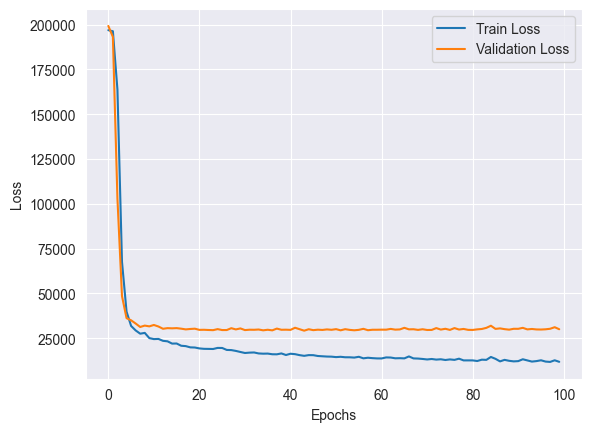

Total parameters: 781313


In [17]:
useful_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'FullBath',
               'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'LotFrontage', 'WoodDeckSF',
               'OpenPorchSF', 'ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
               'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
target_col = 'SalePrice'

# Select columns for training and preprocessing
df_train_prepro = df_train[useful_cols + [target_col]].copy()

# Identify numeric and categorical columns
numeric_cols = df_train_prepro.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_train_prepro.select_dtypes(exclude=[np.number]).columns.tolist()

# For numeric columns, fill with mean
df_train_prepro[numeric_cols] = df_train_prepro[numeric_cols].fillna(df_train_prepro[numeric_cols].mean())

# For categorical columns, fill with mode or a placeholder value
for col in categorical_cols:
    df_train_prepro[col] = df_train_prepro[col].fillna(df_train_prepro[col].mode()[0])

# One-hot encoding for categorical features
categorical_features = ['ExterQual', 'Neighborhood', 'MSZoning', 'Alley', 'LotShape', 
                        'LandContour', 'Condition1', 'HouseStyle', 'MasVnrType', 'SaleCondition']
df_train_prepro = pd.get_dummies(df_train_prepro, columns=categorical_features)

# Split dataset into features and target
X = df_train_prepro.drop(target_col, axis=1)
y = df_train_prepro[target_col]

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define MLP Model
class MLP_extended(nn.Module):
    def __init__(self, input_size):
        super(MLP_extended, self).__init__()
        # Adjust the input size for the first layer based on the dataset's feature count
        self.fc1 = nn.Linear(input_size, 1024)  # Adjust input size dynamically
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 1)  # Assuming the output is a single value for regression
        self.relu = nn.ReLU()

    def forward(self, x):
        # No need to reshape x here, assuming x is already of the correct shape
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc6(self.relu(self.fc5(x)))  # Pass through the additional layer
        return x

input_size = X_train_tensor.shape[1]
model = MLP_extended(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        rmse_loss = torch.sqrt(loss)  # Calculate RMSE
        rmse_loss.backward()
        optimizer.step()
        total_loss += rmse_loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            rmse_loss = torch.sqrt(loss)  # Calculate RMSE
            total_val_loss += rmse_loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Evaluation
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        output = model(X_batch)
        y_pred.extend(output.view(-1).tolist())
        y_true.extend(y_batch.view(-1).tolist())

mse = mean_squared_error(y_true, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')
# Plot training and validation loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params}')
torch.save(model, 'model_complete.pth')